In [3]:
import yfinance as yf
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
df = yf.download('AAPL', start='2022-01-10', end='2023-01-10')

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-10,169.080002,172.500000,168.169998,172.190002,170.244858,106765600
2022-01-11,172.320007,175.179993,170.820007,175.080002,173.102188,76138300
2022-01-12,176.119995,177.179993,174.820007,175.529999,173.547089,74805200
2022-01-13,175.779999,176.619995,171.789993,172.190002,170.244858,84505800
2022-01-14,171.339996,173.779999,171.089996,173.070007,171.114899,80440800


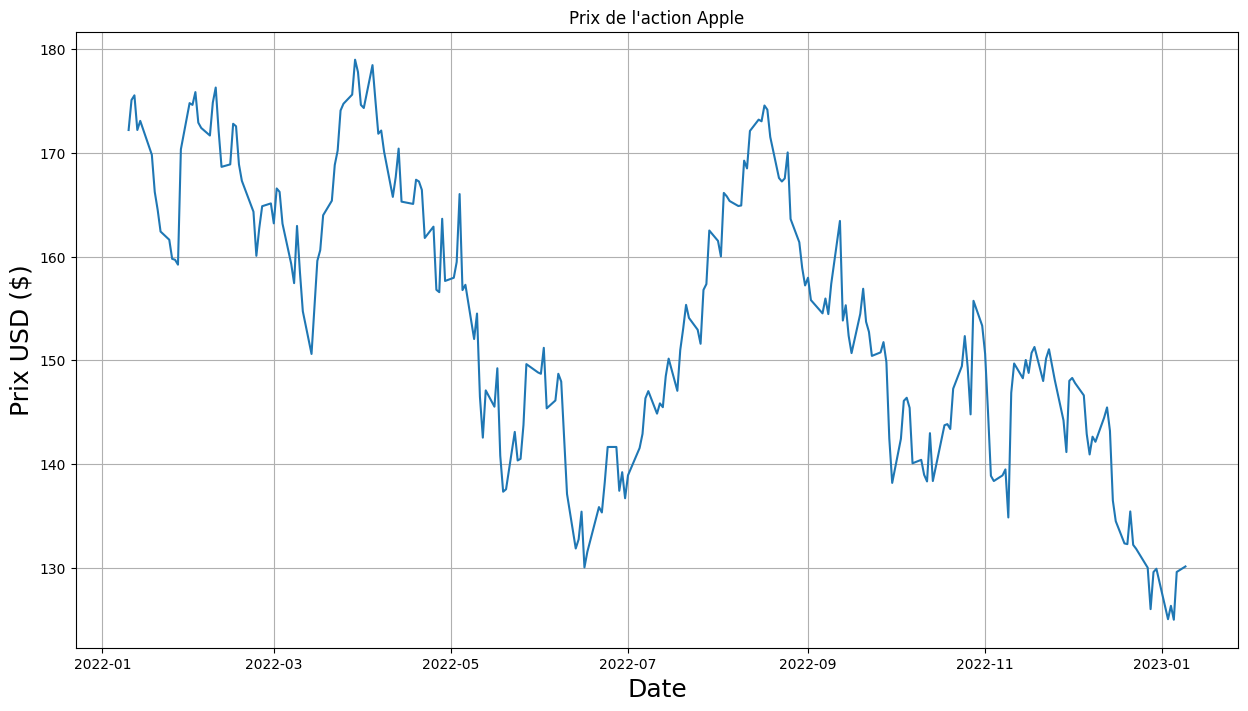

In [6]:
plt.figure(figsize=(15, 8))
plt.title('Prix de l\'action Apple')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix USD ($)', fontsize=18)
plt.grid()
plt.show()